# Molecule analysis Stage 1

In [53]:
#seperate FP analysis
# make sure that data stored is easy (formate etc.) to access and read

# Experiment Imports / Functions: 

In [54]:
import time 
import selfies
import rdkit
import random
import numpy as np
import random
from rdkit import Chem
from selfies import encoder, decoder
from rdkit.Chem import MolFromSmiles as smi2mol
from rdkit.Chem import AllChem
from rdkit.DataStructs.cDataStructs import TanimotoSimilarity
from rdkit.Chem import Mol
from rdkit.Chem.AtomPairs.Sheridan import GetBPFingerprint, GetBTFingerprint
from rdkit.Chem.Pharm2D import Generate, Gobbi_Pharm2D
from rdkit.Chem import Draw
from rdkit.Chem.Descriptors import NumRadicalElectrons

from rdkit.Chem import MolToSmiles as mol2smi
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

import Stoned

In [55]:
import matplotlib.pyplot as plt
import pandas as pd
import pickle

# Parent Molecules
molecules being mutated

In [56]:
smi_dict = pickle.load(open("Mol_list_to_mutate.pkl",'rb'))
parent_mol_names = [key for key in smi_dict.keys()]
#smi -> mol
mols = [Chem.MolFromSmiles(smi) for smi in smi_dict.values()]
legends = [name for name in smi_dict.keys()]
img=Draw.MolsToGridImage(mols,molsPerRow=3,legends=legends)
img

In [57]:
smi_dict

{'PXZ-TRZ': 'c7ccc(c6nc(c1ccccc1)nc(c5ccc(n4c2ccccc2oc3ccccc34)cc5)n6)cc7',
 'TXO-PhCz': 'O=C6c1ccccc1S(=O)(=O)c7ccc(c2ccc4c(c2)c3ccccc3n4c5ccccc5)cc67',
 'TXO-TPA': 'O=C5c1ccccc1S(=O)(=O)c6ccc(c4ccc(N(c2ccccc2)c3ccccc3)cc4)cc56',
 'GOBVUP': 'Clc4ccc(c3csc(=c2scc(c1ccc(Cl)cc1)s2)s3)cc4',
 'TUFWAS': 'c6csc(c4sc(=c3sc(c1cccs1)c(c2cccs2)s3)sc4c5cccs5)c6',
 'YAFNOI': 'c1ccc3c(c1)c2ccccc2S36c4ccccc4c5ccccc56'}

In [58]:
for i,mol in enumerate(mols):
    img = Draw.MolToImage(mol)
    img.save("images/"+parent_mol_names[i]+"_MolFromSmiles.png",bbox_inches='tight')

Data (output) from "PART_1_Molecule_generator_exhaustive_searchb.ipynb"

## How many molecules do we need to generate initally, to exhaust maximum number of possible unique molecules?

In [59]:
import os

In [60]:
#extract unique SMILES from a list of all generated SMILES and index them
def extract_unique_smi_ls(all_smiles_collect):
    canon_smi_ls = []
    for i,item in enumerate(all_smiles_collect): 
        # Return a canonical smile representation of smi
        mol, smi_canon, did_convert = Stoned.sanitize_smiles(item)
        if mol == None or smi_canon == '' or did_convert == False: 
            raise Exception('Invalid smile string found')
        canon_smi_ls.append(smi_canon)
    l = canon_smi_ls
    idxs = []
    seen = set()
    for i, ele in enumerate(l):
        if ele not in seen:
            idxs.append(i)
        seen.add(ele)
    return list(seen), idxs

In [61]:
# Put all SMILES in a dict, for easy data access 

all_smi_data = {}
# all_canon_smi_data = {}
for parent in parent_mol_names:
    files = [file for file in os.listdir('.') if parent+'_1' in file and 'all_smi_lists.pkl' in file]
    pop_gen_ls = [int(file.split("_")[3]) for file in files]
    max_gen_num = max(pop_gen_ls)
    
    all_smi_data[parent] = pickle.load(open(parent+"_1_mutation_"+str(max_gen_num)+"_all_smi_lists.pkl",'rb'))
    
    files = [file for file in os.listdir('.') if parent+'_1' in file and 'canon_smi_lists.pkl' in file]
    pop_gen_ls = [int(file.split("_")[3]) for file in files]
    max_gen_num = max(pop_gen_ls)
    
    all_canon_smi_data[parent] = pickle.load(open(parent+"_1_mutation_"+str(max_gen_num)+"_canon_smi_lists.pkl",'rb'))

In [62]:
pickle.dump(all_smi_data,open("all_smi_data.pkl",'wb'))

In [63]:
all_smi_data = pickle.load(open("all_smi_data.pkl",'rb'))

Extract unique SMILES only, this process can take time if there are lots of molecule. For that reason, the output can be saved as a pickle file to save time.

In [64]:
if 'all_unique_smi_data.pkl' not in os.listdir():
    print('extracting unique SMILES from all_smi_data')
    all_unique_smi_data = {}
    for parent in parent_mol_names:
        all_unique_smi_data[parent] = extract_unique_smi_ls(all_smi_data[parent])
    print('saving pickel file: all_unique_smi_data.pkl')
    pickle.dump(all_unique_smi_data,open("all_unique_smi_data.pkl",'wb'))
else:
    print('all_unique_smi_data.pkl already EXISTS')
    all_unique_smi_data = pickle.load(open("all_unique_smi_data.pkl",'rb'))

all_unique_smi_data.pkl already EXISTS


In [65]:
# imge resolution
img_dpi = 300

In [66]:
markers = ['<', '+', 'x', 'o', 's', '+']
for i,parent in enumerate(parent_mol_names):
    if parent != 'YAFNOI':
        y_unique = [len(all_unique_smi_data[parent][0][:i]) for i in range(len(all_unique_smi_data[parent][0]))]
        x_unique = all_unique_smi_data[parent][1]

        plt.scatter(x=x_unique,y=y_unique,label=parent,marker=markers[i],alpha=0.5)
        plt.legend()
    
    
plt.xlabel('SMILES generated')
plt.ylabel('Canonical SMILES')
plt.xlim([-5000,100000])

# plt.grid()
plt.savefig('Images/SMILES_generated_v_unique_SMILES_obtained.png', bbox_inches='tight', dpi=img_dpi)
plt.show()

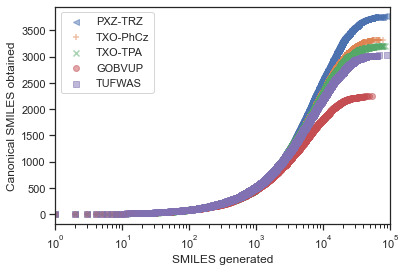

In [67]:
markers = ['<', '+', 'x', 'o', 's', '+']
for i,parent in enumerate(parent_mol_names):
    if parent != 'YAFNOI':
        y_unique = [len(all_unique_smi_data[parent][0][:i]) for i in range(len(all_unique_smi_data[parent][0]))]
        x_unique = all_unique_smi_data[parent][1]

        plt.scatter(x=x_unique,y=y_unique,label=parent,marker=markers[i],alpha=0.5)
        plt.legend()
    
    
plt.xlabel('SMILES generated')
plt.ylabel('Canonical SMILES obtained')
plt.xscale('log')
# plt.yscale('log')
plt.xlim([1,100000])


# plt.grid()
plt.savefig('Images/SMILES_generated_v_unique_SMILES_obtained.png', bbox_inches='tight', dpi=img_dpi)
plt.show()

In [68]:
for parent in parent_mol_names:
    print(parent, len(all_unique_smi_data[parent][0]), (len(all_unique_smi_data[parent][0])/len(all_smi_data[parent]))*100,'%',len(all_smi_data[parent]) )

PXZ-TRZ 3769 2.791851851851852 % 135000
TXO-PhCz 3325 2.891304347826087 % 115000
TXO-TPA 3210 2.3777777777777778 % 135000
GOBVUP 2247 2.365263157894737 % 95000
TUFWAS 3026 2.881904761904762 % 105000
YAFNOI 1925 1.8333333333333333 % 105000


In [69]:
x = parent_mol_names
y1 = [len(all_smi_data[parent]) for parent in parent_mol_names]
y2 = [ len(all_unique_smi_data[parent][0]) for parent in parent_mol_names]
width = 0.35

# plot bars in stack manner
plt.bar(x, y1, color='r')
plt.bar(x, y2, bottom=y1, color='b')
plt.legend(["Total", "Unique"])
plt.xlabel("Parent Molecule")
plt.ylabel("Number of Molecules")
for i, v in enumerate(y2):
    plt.text(i - 0.25, v + 1000+ y1[i], str(v))
plt.show()

# Put all SMILES from each family into a dataframe/dictionary without nested keys

In [70]:
all_data = {}
all_data['Family'] = []
all_data['SMILES'] = []
for parent in parent_mol_names:
    all_data['Family'].extend([parent for smi in all_unique_smi_data[parent][0]])
    all_data['SMILES'].extend([smi for smi in all_unique_smi_data[parent][0]])
pd.DataFrame(all_data)

Family                                             SMILES
0      PXZ-TRZ  NC1=CC=CCC2(C=CC=CC3=CC=C(C=N2)SC=C3)c2ccccc2O...
1      PXZ-TRZ  C#CC=CC=[SH]CC1(N=CC2=CC(=C)C=CS2)CC=CC=C(N)N=...
2      PXZ-TRZ                 ICC=Cc1nc(-c2ccccc2)ncc2ccc(cc2)n1
3      PXZ-TRZ  C=CCC1=CC=CCN=C(c2ccccc2)N=CC2=CC(=C=C=CC=CC=C...
4      PXZ-TRZ  C=S=CC(=CC=CC1C=C2C=CSC(=C2)C=NC(c2ccccc2)=N1)...
...        ...                                                ...
17497   YAFNOI   C1#P=C([SH]2c3ccccc3-c3ccccc32)C(=Cc2ccccc2)C=C1
17498   YAFNOI  C1=CC2=C([SH]3c4ccccc4-c4ccccc43)c3ccccc3[N+]2...
17499   YAFNOI              [N-]=Cc1ccccc1[SH]1c2ccccc2-c2ccccc21
17500   YAFNOI        C1=CC=C2C(N=1)c1ccccc1S21c2ccccc2-c2ccccc21
17501   YAFNOI  C(c1ccccc1)#[S+]1=CC=CC=C1[SH]1c2ccccc2-c2ccccc21

[17502 rows x 2 columns]

#### Does number of molecules generated depend on the parent molecule size?

In [71]:
parent_data = {}
parent_data['molecule'] = []
parent_data['n_atoms'] = []
parent_data['SMILES'] = []
parent_data['Unique_molecues'] = []
parent_data['SMILES_generated'] = []

parent_smi_natoms = {}
max_gen_pop = {}
for name in smi_dict.keys():
    parent_data['molecule'].append(name)
    mol = Chem.MolFromSmiles(smi_dict[name])
    atoms_ls = [atom.GetSymbol() for atom in mol.GetAtoms()]
    n_atoms = len(atoms_ls)
    parent_smi_natoms[name] = [n_atoms]
    parent_data['n_atoms'].append(n_atoms)
    parent_data['SMILES'].append(smi_dict[name])
    parent_data['Unique_molecues'].append(len(all_unique_smi_data[name][0]))
    parent_data['SMILES_generated'].append(len(all_smi_data[name]))

In [72]:
pd.DataFrame(parent_data)

molecule  n_atoms                                             SMILES  \
0   PXZ-TRZ       38  c7ccc(c6nc(c1ccccc1)nc(c5ccc(n4c2ccccc2oc3cccc...   
1  TXO-PhCz       36  O=C6c1ccccc1S(=O)(=O)c7ccc(c2ccc4c(c2)c3ccccc3...   
2   TXO-TPA       36  O=C5c1ccccc1S(=O)(=O)c6ccc(c4ccc(N(c2ccccc2)c3...   
3    GOBVUP       24        Clc4ccc(c3csc(=c2scc(c1ccc(Cl)cc1)s2)s3)cc4   
4    TUFWAS       30  c6csc(c4sc(=c3sc(c1cccs1)c(c2cccs2)s3)sc4c5ccc...   
5    YAFNOI       25            c1ccc3c(c1)c2ccccc2S36c4ccccc4c5ccccc56   

   Unique_molecues  SMILES_generated  
0             3769            135000  
1             3325            115000  
2             3210            135000  
3             2247             95000  
4             3026            105000  
5             1925            105000

In [73]:
parent_data
pickle.dump(parent_data,open('parent_data.pkl','wb'))

##### Generated SMILES vs Atom size

this does not matter becasue the progam will generate however many molecule you tell it to generate, even if there are duplicates.

##### Unique smiles vs Atom size

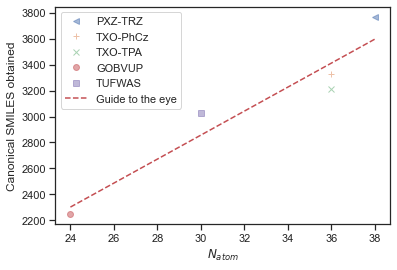

In [74]:
df = pd.DataFrame(all_data)
markers = ['<', '+', 'x', 'o', 's', '+']
x = []
y = []
for i,name in enumerate(parent_data['molecule']):
    if name != 'YAFNOI':
        plt.plot(parent_data['n_atoms'][i],df.query("Family ==@name").shape[0],linestyle='none',marker=markers[i],label=name,alpha=0.5)
        # Sort the data points by the x values
        y.append(df.query("Family ==@name").shape[0])
        x.append(parent_data['n_atoms'][i])

# Sort the data points by the x values
sorted_indices = np.argsort(x)
sorted_x = [x[i] for i in sorted_indices]
sorted_y = [y[i] for i in sorted_indices]
    
    
coefficients = np.polyfit(sorted_x, sorted_y, 1)
p = np.poly1d(coefficients)
plt.plot(sorted_x,p(sorted_x),"r--", label='Guide to the eye')   
    
plt.xlabel('$N_{atom}$')
# plt.xticks(rotation=90)
plt.ylabel('Canonical SMILES obtained')
    
# plt.legend(bbox_to_anchor=(1.01, 1),prop={'size': 12})
plt.legend()
plt.savefig('Images/Nunique_v_atom_size.png', bbox_inches='tight',dpi=img_dpi)
plt.show()

### Not all unique molecules generated are meaning full. 

let us look at average size of molecules

In [75]:
def calc_natoms(smi):
    mol = Chem.MolFromSmiles(smi)
    atoms_ls = [atom.GetSymbol() for atom in mol.GetAtoms()]
    n_atoms = len(atoms_ls)
    return n_atoms

In [76]:
all_data['Natoms'] = []
for smi in all_data['SMILES']:
    all_data['Natoms'].append(calc_natoms(smi))

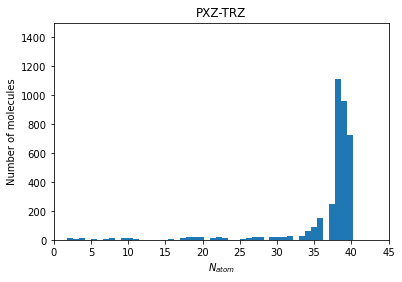

Parent molecule size 38


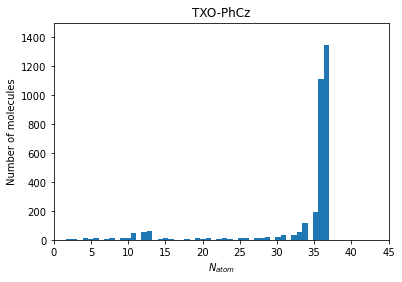

Parent molecule size 36


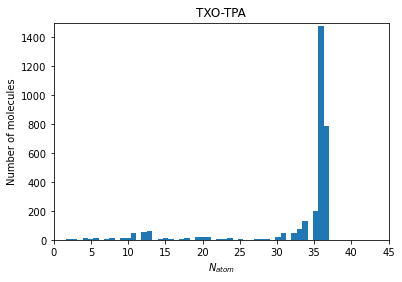

Parent molecule size 36


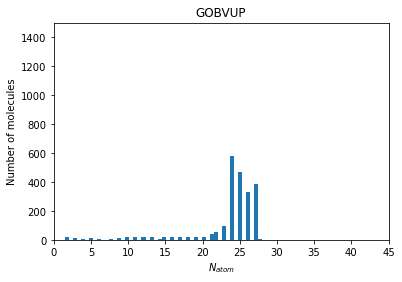

Parent molecule size 24


Parent molecule size 30


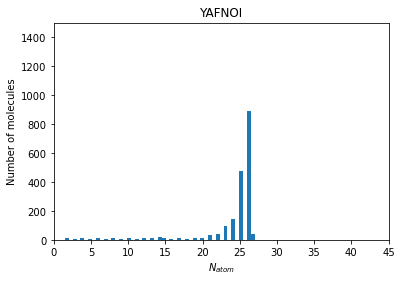

Parent molecule size 25


In [25]:
for i,Family in enumerate(parent_data['molecule']):
    pd.DataFrame(all_data).query("Family == @Family")['Natoms'].plot.hist(bins=50)
    plt.title(Family)
    plt.xlabel("$N_{atom}$")
    plt.ylabel("Number of molecules")
    plt.xlim(0, 45)
    plt.ylim(0, 1500)
    plt.savefig('Images/hist_'+Family+'_Natoms.png', bbox_inches='tight',dpi=img_dpi)
    plt.show()
    print("Parent molecule size",parent_data['n_atoms'][i])

Majority of molecules exists at the higher frequency level


molecules less than the parent size is not necessary as they would resemble complete different molecule

# Get rid of atoms that are below certain number of the original atom

atom_thresh = 10, meaning 10 atoms less than parent molecule 


second thought can do this later

TODO: Get rid of make sure that atoms with small mols are not included

In [26]:
atom_thresh = 10

In [27]:
df_parents_n_atoms = pd.DataFrame(parent_smi_natoms)
df_parents_n_atoms

PXZ-TRZ  TXO-PhCz  TXO-TPA  GOBVUP  TUFWAS  YAFNOI
0       38        36       36      24      30      25

In [29]:
pd.DataFrame(all_data).query("Family == @Family")

Family                                             SMILES  Natoms
15577  YAFNOI      C=C1C#P=C2C(=C1)c1ccccc1S21c2ccccc2-c2ccccc21      26
15578  YAFNOI      C#CC=CC=CC1=CC=C[S-]2#[SH]1c1ccccc1-c1ccc2cc1      24
15579  YAFNOI   C=C1C=CC2=[P-](=C1)c1ccccc1S21c2ccccc2-c2ccccc21      26
15580  YAFNOI   c1ccc2c(c1)-c1ccccc1[SH]2c1c2cc[nH]cc-2c2ccccc12      26
15581  YAFNOI          C=CC=C1C[N-]c2ccccc2S12c1ccccc1-c1ccccc12      25
...       ...                                                ...     ...
17497  YAFNOI   C1#P=C([SH]2c3ccccc3-c3ccccc32)C(=Cc2ccccc2)C=C1      26
17498  YAFNOI  C1=CC2=C([SH]3c4ccccc4-c4ccccc43)c3ccccc3[N+]2...      26
17499  YAFNOI              [N-]=Cc1ccccc1[SH]1c2ccccc2-c2ccccc21      21
17500  YAFNOI        C1=CC=C2C(N=1)c1ccccc1S21c2ccccc2-c2ccccc21      25
17501  YAFNOI  C(c1ccccc1)#[S+]1=CC=CC=C1[SH]1c2ccccc2-c2ccccc21      26

[1925 rows x 3 columns]

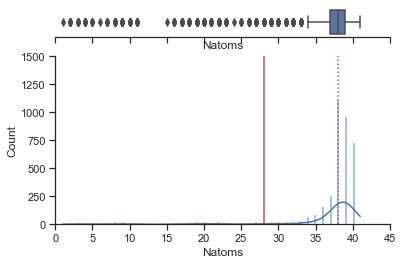

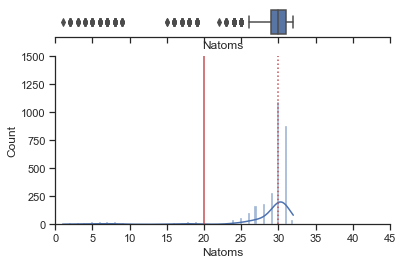

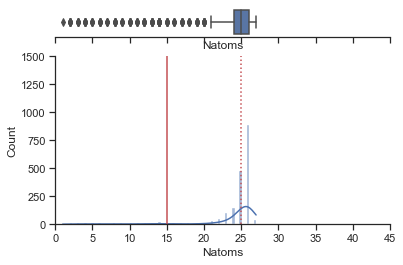

In [30]:
import seaborn as sns

sns.set(style="ticks")

for i,Family in enumerate(parent_data['molecule']):
    
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
    df = pd.DataFrame(all_data).query("Family == @Family")
    sns.boxplot(data=df,x='Natoms', ax=ax_box)
    sns.histplot(data=df,x='Natoms', ax=ax_hist, kde=True)
    
    ax_box.set(yticks=[])
    sns.despine(ax=ax_hist)
    sns.despine(ax=ax_box, left=True)
    
    x_vline_th = parent_data['n_atoms'][i] - atom_thresh
    x_vline = parent_data['n_atoms'][i]
    plt.axvline(x=x_vline_th, color='r')
    plt.axvline(x=x_vline,color='r', linestyle=':')
    plt.xlim(0, 45)
    plt.ylim(0, 1500)

38


Parent molecule size 38
36


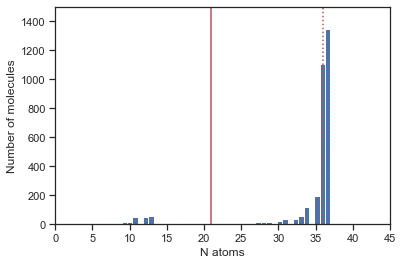

Parent molecule size 36
36


Parent molecule size 36
24


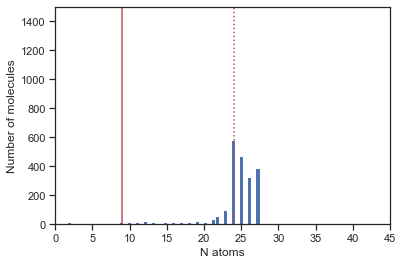

Parent molecule size 24
30


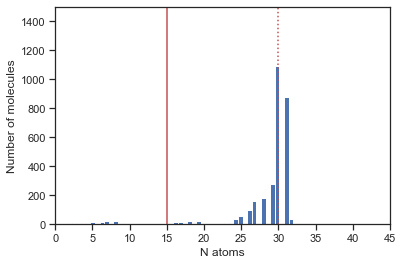

Parent molecule size 30
25


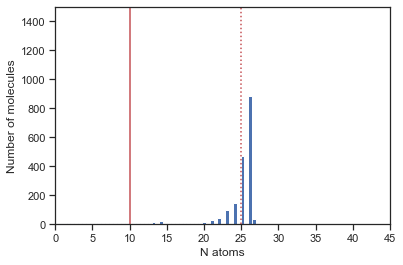

Parent molecule size 25


In [78]:
for i,Family in enumerate(parent_data['molecule']):
    pd.DataFrame(all_data).query("Family == @Family")['Natoms'].plot.hist(bins=50)
    x_vline_th = parent_data['n_atoms'][i] - atom_thresh
    x_vline = parent_data['n_atoms'][i]
#     plt.title(Family)
    plt.xlabel("N atoms")
    plt.ylabel("Number of molecules")
    plt.xlim(0, 45)
    plt.ylim(0, 1500)
    print(x_vline)
    plt.axvline(x=x_vline_th, color='r')
    plt.axvline(x=x_vline,color='r', linestyle=':')
    plt.savefig('Images/hist_'+Family+'_Natoms.png', bbox_inches='tight',dpi=img_dpi)
    plt.show()
    print("Parent molecule size",parent_data['n_atoms'][i])

# Calculate fingerprint Score

In [32]:
# Calculaitng finger print scores for all the molecules generated, compare to the parent first
fp_type = 'ECFP4'
all_data['fp_score'] = []

start_time = time.time()

for i, smi in enumerate(all_data['SMILES']):
    parent_smi = smi_dict[all_data['Family'][i]]
    all_data['fp_score'].append(Stoned.get_fp_scores([smi],target_smi=parent_smi,fp_type=fp_type)[0])
print('Fingerprint calculation time: ', time.time()-start_time)

Fingerprint calculation time:  16.325838804244995


# What does molecules with low number of atoms look like?

In [33]:
low_natom_df = pd.DataFrame()

for i,Family in enumerate(parent_data['molecule']):
    thresh = parent_data['n_atoms'][i] -10
    data = pd.DataFrame(all_data).query("Family == @Family").query("Natoms <= @thresh")
    low_natom_df = low_natom_df.append( data,ignore_index=True)
low_natom_df

Family                                SMILES  Natoms  fp_score
0     PXZ-TRZ    ICC=Cc1nc(-c2ccccc2)ncc2ccc(cc2)n1      22  0.260563
1     PXZ-TRZ                            C=CC=C[O-]       5  0.000000
2     PXZ-TRZ  [O-]C=Cc1nc(-c2ccccc2)ncc2ccc(cc2)n1      21  0.266187
3     PXZ-TRZ    O=C=Cc1nc(-c2ccccc2)ncc2ccc(cc2)n1      21  0.266187
4     PXZ-TRZ                         FC1=CC=CC=CS1       8  0.045802
...       ...                                   ...     ...       ...
1577   YAFNOI                                C=CC#N       4  0.000000
1578   YAFNOI                   Clc1ccccc1-c1ccccc1      13  0.313953
1579   YAFNOI                   BrC=CC=CC=Cc1ccccc1      13  0.130000
1580   YAFNOI                        ClCC=Cc1ccccc1      10  0.142857
1581   YAFNOI                        C=CC=Cc1ccccc1      10  0.142857

[1582 rows x 4 columns]

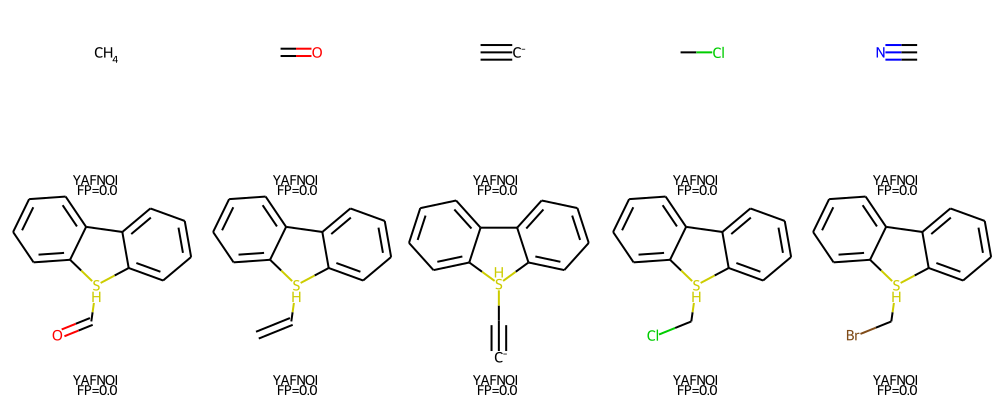

In [34]:
for fam in parent_data['molecule']:
    df= low_natom_df.query("Family == @fam").sort_values("Natoms")
    sliced_df = df.head(5)
    sliced_df = sliced_df.append(df.tail(5))

    mut_mols = [Chem.MolFromSmiles(smi) for smi in sliced_df['SMILES']]
    legends = [name+'\nFP='+str(sliced_df['fp_score'].values[0]) for i,name in enumerate(sliced_df['Family'])]
    #returnPNG=False need here Not sure why, otherwise img wont save 
    img=Draw.MolsToGridImage(mut_mols,molsPerRow=5,subImgSize=(200,200),legends=legends,returnPNG=False)
    img.save("images/"+fam+"_Natoms_lt_thresh.png")#,bbox_inches='tight')
img

# N atoms vs fp scores

In [35]:
pd.DataFrame(all_data)

Family                                             SMILES  Natoms  \
0      PXZ-TRZ  NC1=CC=CCC2(C=CC=CC3=CC=C(C=N2)SC=C3)c2ccccc2O...      36   
1      PXZ-TRZ  C#CC=CC=[SH]CC1(N=CC2=CC(=C)C=CS2)CC=CC=C(N)N=...      39   
2      PXZ-TRZ                 ICC=Cc1nc(-c2ccccc2)ncc2ccc(cc2)n1      22   
3      PXZ-TRZ  C=CCC1=CC=CCN=C(c2ccccc2)N=CC2=CC(=C=C=CC=CC=C...      39   
4      PXZ-TRZ  C=S=CC(=CC=CC1C=C2C=CSC(=C2)C=NC(c2ccccc2)=N1)...      39   
...        ...                                                ...     ...   
17497   YAFNOI   C1#P=C([SH]2c3ccccc3-c3ccccc32)C(=Cc2ccccc2)C=C1      26   
17498   YAFNOI  C1=CC2=C([SH]3c4ccccc4-c4ccccc43)c3ccccc3[N+]2...      26   
17499   YAFNOI              [N-]=Cc1ccccc1[SH]1c2ccccc2-c2ccccc21      21   
17500   YAFNOI        C1=CC=C2C(N=1)c1ccccc1S21c2ccccc2-c2ccccc21      25   
17501   YAFNOI  C(c1ccccc1)#[S+]1=CC=CC=C1[SH]1c2ccccc2-c2ccccc21      26   

       fp_score  
0      0.284884  
1      0.225806  
2      0.260563  
3      0.277778  
4      0.393939  
...         ...  
17497  0.416667  
17498  0.457143  
17499  0.412371  
17500  0.578947  
17501  0.416667  

[17502 rows x 4 columns]

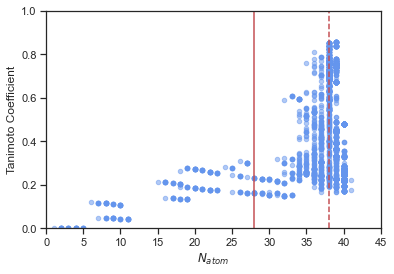

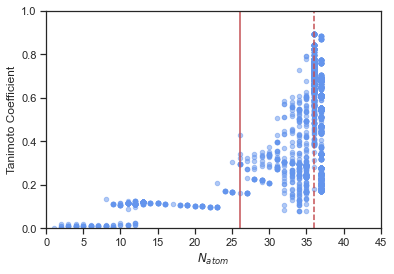

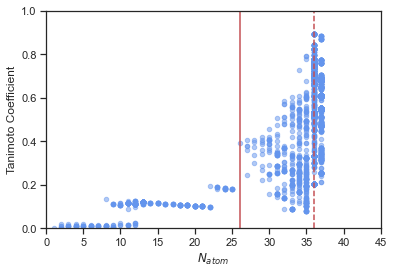

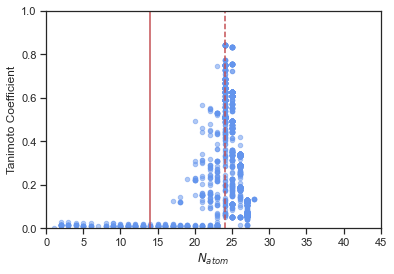

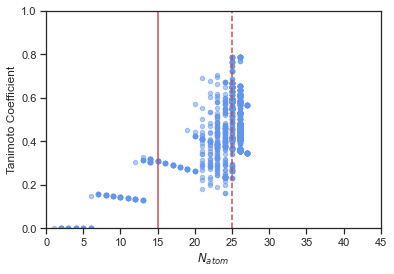

In [36]:
# img_dpi = 300
for i,fam in enumerate(parent_data['molecule']):
#     thresh = parent_data['natoms'][i] - 10
    
    df= pd.DataFrame(all_data).query('fp_score != 1').query('Family == @fam')#.query("N_atoms >= @thresh").query("shell == 'closed'")
#     df= df_5.query('Family == @fam').query("N_atoms >= @thresh").query('shell == "closed"').query("LambdaT <= @og_lambdaT").query("LUMO-HOMO <= @og_HL")
    ax = df.plot.scatter(x='Natoms',y='fp_score',c='cornflowerblue',colormap='viridis', alpha=0.5,sharex=False)
    plt.axvline(x=parent_data['n_atoms'][i],color='r',label='Parent molecule',ls='--')
    plt.axvline(x=parent_data['n_atoms'][i]-10,color='r',label='Parent molecule')

    ax.set_xlabel("$N_{atom}$")
    ax.set_ylabel("Tanimoto Coefficient")
    
    ax.set_ylim([0,1])
    ax.set_xlim([0,45])
    plt.savefig('Images/Scatter_FP_vs_MS'+fam+'.png', bbox_inches='tight',dpi=img_dpi)
    plt.show()

# Open shell or close shell

In [37]:
from rdkit.Chem.Descriptors import NumRadicalElectrons

In [38]:
all_data['shell_type'] = []
for smi in all_data['SMILES']:
#     The number of radical electrons the molecule has
#     NumValenceElectrons is also an options # do this as well see if the number changes
    num_Rad = NumRadicalElectrons(Chem.MolFromSmiles(smi))
    if num_Rad == 0:
        all_data['shell_type'].append('Closed')
    else:
        all_data['shell_type'].append('Open')

PXZ-TRZ
Number of closed= 2725 open= 759
0.7821469575200919 0.21785304247990814
without any filter 3484 , difference= 759


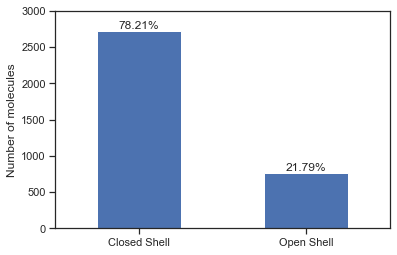

TXO-PhCz
Number of closed= 2257 open= 714
0.7596768764725682 0.24032312352743185
without any filter 2971 , difference= 714


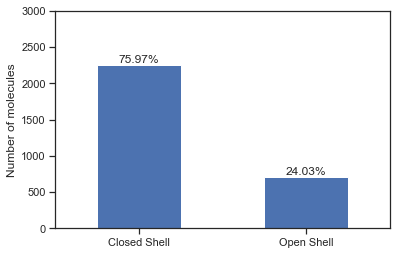

TXO-TPA
Number of closed= 2147 open= 667
0.7629708599857854 0.23702914001421463
without any filter 2814 , difference= 667


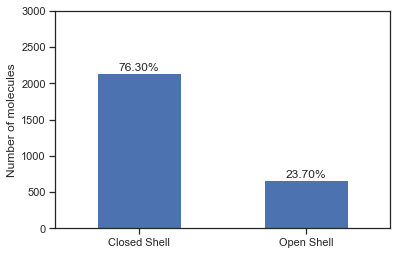

GOBVUP
Number of closed= 1610 open= 477
0.7714422616195495 0.2285577383804504
without any filter 2087 , difference= 477


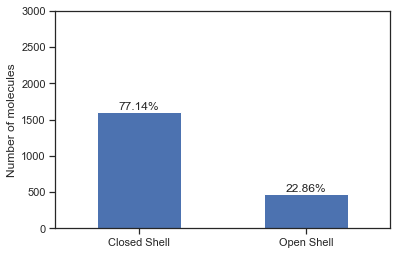

TUFWAS
Number of closed= 2298 open= 533
0.8117273048392794 0.1882726951607206
without any filter 2831 , difference= 533


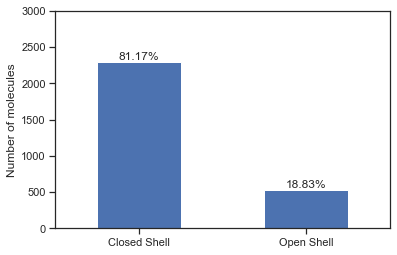

YAFNOI
Number of closed= 1410 open= 374
0.7903587443946188 0.20964125560538116
without any filter 1784 , difference= 374


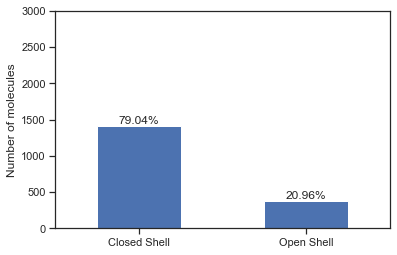

In [39]:
df_filter1 = pd.DataFrame() # reset
df = pd.DataFrame(all_data)
for i, family in enumerate(parent_data['molecule']):
    parent_natoms = parent_data['n_atoms'][i]
    df_filter1 = df.query("Family == @family").query("Natoms >= (@parent_natoms - @atom_thresh)")
    value_counts = df_filter1['shell_type'].value_counts()
    ax = value_counts.plot(kind='bar')
    
#     plt.title(family)
#     plt.xlabel("Shell type")
    plt.xticks([0,1],['Closed Shell', 'Open Shell'],rotation=0)
    plt.ylabel("Number of molecules")
    plt.ylim(0, 3000)


    print(family)
    print("Number of closed=", value_counts[0], 'open=',value_counts[1])
#     total = df.query("Family == @family").shape[0]
    total = df_filter1.query("Family == @family").shape[0]
    print(value_counts[0]/total,value_counts[1]/total)
    print("without any filter", total, ', difference=' , value_counts[1])
    
    rects = ax.patches
    labels = [str("{:.2f}".format(value_counts[0]*100/total))+'%', str("{:.2f}".format(value_counts[1]*100/total))+'%']
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2, height + 5, label, ha="center", va="bottom"
        )
    plt.savefig('Images/bar_'+family+'_shelltype.png', bbox_inches='tight',dpi=img_dpi)
    plt.show()

# Giving molecules names

give name to molecules after being filtered

In [40]:
all_data['molecule'] = []

for parent in parent_data['molecule']:
    
    idx = 1
    for i,mol in enumerate(all_data['Family']):
        if parent == mol:
            mol_name = all_data['Family'][i]+'_'+str(idx)
            all_data['molecule'].append(mol_name)
        
            idx += 1

In [41]:
pd.DataFrame(all_data)

Family                                             SMILES  Natoms  \
0      PXZ-TRZ  NC1=CC=CCC2(C=CC=CC3=CC=C(C=N2)SC=C3)c2ccccc2O...      36   
1      PXZ-TRZ  C#CC=CC=[SH]CC1(N=CC2=CC(=C)C=CS2)CC=CC=C(N)N=...      39   
2      PXZ-TRZ                 ICC=Cc1nc(-c2ccccc2)ncc2ccc(cc2)n1      22   
3      PXZ-TRZ  C=CCC1=CC=CCN=C(c2ccccc2)N=CC2=CC(=C=C=CC=CC=C...      39   
4      PXZ-TRZ  C=S=CC(=CC=CC1C=C2C=CSC(=C2)C=NC(c2ccccc2)=N1)...      39   
...        ...                                                ...     ...   
17497   YAFNOI   C1#P=C([SH]2c3ccccc3-c3ccccc32)C(=Cc2ccccc2)C=C1      26   
17498   YAFNOI  C1=CC2=C([SH]3c4ccccc4-c4ccccc43)c3ccccc3[N+]2...      26   
17499   YAFNOI              [N-]=Cc1ccccc1[SH]1c2ccccc2-c2ccccc21      21   
17500   YAFNOI        C1=CC=C2C(N=1)c1ccccc1S21c2ccccc2-c2ccccc21      25   
17501   YAFNOI  C(c1ccccc1)#[S+]1=CC=CC=C1[SH]1c2ccccc2-c2ccccc21      26   

       fp_score shell_type     molecule  
0      0.284884     Closed    PXZ-TRZ_1  
1      0.225806     Closed    PXZ-TRZ_2  
2      0.260563     Closed    PXZ-TRZ_3  
3      0.277778     Closed    PXZ-TRZ_4  
4      0.393939     Closed    PXZ-TRZ_5  
...         ...        ...          ...  
17497  0.416667     Closed  YAFNOI_1921  
17498  0.457143       Open  YAFNOI_1922  
17499  0.412371     Closed  YAFNOI_1923  
17500  0.578947     Closed  YAFNOI_1924  
17501  0.416667       Open  YAFNOI_1925  

[17502 rows x 6 columns]

In [42]:
pickle.dump(all_data, open("the_data_NEW.pkl",'wb'))

# NET Charge

In [43]:
from rdkit.Chem import rdPartialCharges

net_charge_data={}
net_charge_data['Net Charge'] = []
net_charge_data['Family'] = []
net_charge_data['Molecule'] = []
for i,smi in enumerate(all_data['SMILES']):
#     The number of radical electrons the molecule has
#     NumValenceElectrons is also an options # do this as well see if the number changes

    
    if all_data['shell_type'][i] == 'Open':
        mol = Chem.MolFromSmiles(smi)
        rdPartialCharges.ComputeGasteigerCharges(mol)
        # Calculate the number of heavy atoms
        total_charge = sum([atom.GetFormalCharge() for atom in mol.GetAtoms()])
        partial_charges = [atom.GetDoubleProp('_GasteigerCharge') for atom in mol.GetAtoms()]
#         print(total_charge,partial_charges)
#         net_charge = round(sum(partial_charges) - total_charge)
        net_charge = sum(partial_charges) - total_charge
        net_charge_data['Net Charge'].append(net_charge)
        net_charge_data['Family'].append(all_data['Family'][i])
        net_charge_data['Molecule'].append(all_data['molecule'][i])
    

In [44]:
pd.DataFrame(net_charge_data)

Net Charge   Family     Molecule
0      -1.489919  PXZ-TRZ    PXZ-TRZ_7
1      -1.748103  PXZ-TRZ    PXZ-TRZ_8
2      -1.459993  PXZ-TRZ   PXZ-TRZ_18
3      -1.393650  PXZ-TRZ   PXZ-TRZ_19
4            NaN  PXZ-TRZ   PXZ-TRZ_20
...          ...      ...          ...
3609   -0.886124   YAFNOI  YAFNOI_1913
3610   -0.959293   YAFNOI  YAFNOI_1914
3611   -1.150898   YAFNOI  YAFNOI_1916
3612   -1.189787   YAFNOI  YAFNOI_1922
3613   -1.243156   YAFNOI  YAFNOI_1925

[3614 rows x 3 columns]

## Looking at FP scores closely

In [45]:
# finger print threshold used to seperate molecules
thresh_list = np.arange(0, 1, 0.1).tolist()

In [46]:
# Calculaitng finger print scores for all the molecules generated, compare to the parent first
fp_type = 'ECFP4'
all_data['fp_score'] = []

start_time = time.time()

for i, smi in enumerate(all_data['SMILES']):
    parent_smi = smi_dict[all_data['Family'][i]]
    all_data['fp_score'].append(Stoned.get_fp_scores([smi],target_smi=parent_smi,fp_type=fp_type)[0])
print('Fingerprint calculation time: ', time.time()-start_time)

In [47]:
pd.DataFrame(all_data)

Family                                             SMILES  Natoms  \
0      PXZ-TRZ  NC1=CC=CCC2(C=CC=CC3=CC=C(C=N2)SC=C3)c2ccccc2O...      36   
1      PXZ-TRZ  C#CC=CC=[SH]CC1(N=CC2=CC(=C)C=CS2)CC=CC=C(N)N=...      39   
2      PXZ-TRZ                 ICC=Cc1nc(-c2ccccc2)ncc2ccc(cc2)n1      22   
3      PXZ-TRZ  C=CCC1=CC=CCN=C(c2ccccc2)N=CC2=CC(=C=C=CC=CC=C...      39   
4      PXZ-TRZ  C=S=CC(=CC=CC1C=C2C=CSC(=C2)C=NC(c2ccccc2)=N1)...      39   
...        ...                                                ...     ...   
17497   YAFNOI   C1#P=C([SH]2c3ccccc3-c3ccccc32)C(=Cc2ccccc2)C=C1      26   
17498   YAFNOI  C1=CC2=C([SH]3c4ccccc4-c4ccccc43)c3ccccc3[N+]2...      26   
17499   YAFNOI              [N-]=Cc1ccccc1[SH]1c2ccccc2-c2ccccc21      21   
17500   YAFNOI        C1=CC=C2C(N=1)c1ccccc1S21c2ccccc2-c2ccccc21      25   
17501   YAFNOI  C(c1ccccc1)#[S+]1=CC=CC=C1[SH]1c2ccccc2-c2ccccc21      26   

       fp_score shell_type     molecule  
0      0.284884     Closed    PXZ-TRZ_1  
1      0.225806     Closed    PXZ-TRZ_2  
2      0.260563     Closed    PXZ-TRZ_3  
3      0.277778     Closed    PXZ-TRZ_4  
4      0.393939     Closed    PXZ-TRZ_5  
...         ...        ...          ...  
17497  0.416667     Closed  YAFNOI_1921  
17498  0.457143       Open  YAFNOI_1922  
17499  0.412371     Closed  YAFNOI_1923  
17500  0.578947     Closed  YAFNOI_1924  
17501  0.416667       Open  YAFNOI_1925  

[17502 rows x 6 columns]

#### FP without filter

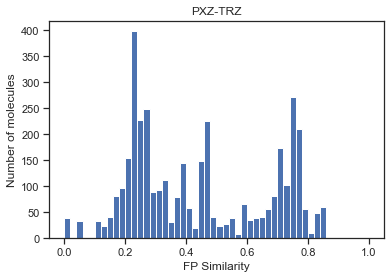

without any filter 1925


without any filter 1925


without any filter 1925


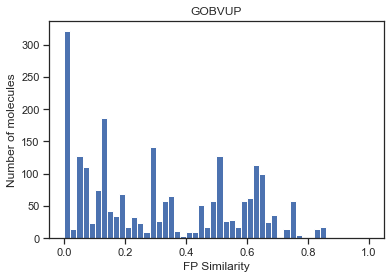

without any filter 1925


without any filter 1925


without any filter 1925


In [48]:
df = pd.DataFrame(all_data)
for i,smi in enumerate(parent_data['SMILES']):
    fam = parent_data['molecule'][i]
    df.query("Family == @fam")['fp_score'].plot.hist(bins=50)
    plt.title(fam)
    plt.xlabel("FP Similarity")
    plt.ylabel("Number of molecules")
#     plt.savefig('Images/hist_'+fam+'_fpSimilarity.png', bbox_inches='tight',dpi=img_dpi)
    plt.show()
    print("without any filter", df.query("Family == @family").shape[0])

##### FP after filter

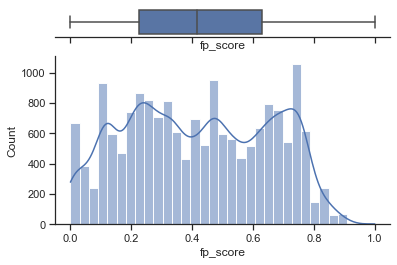

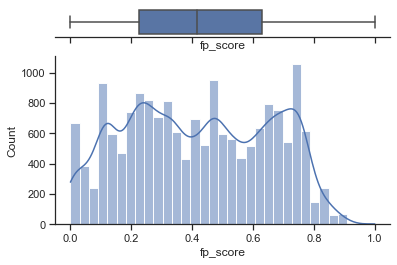

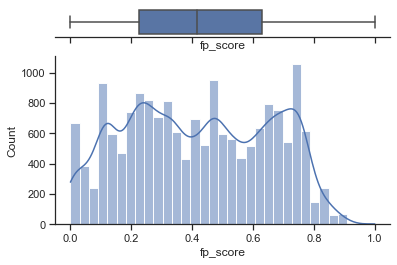

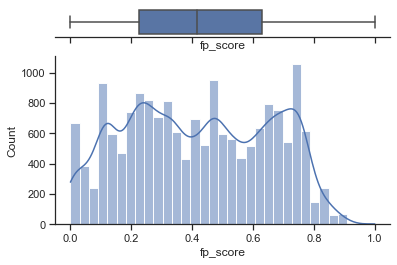

In [49]:
sns.set(style="ticks")

for i,Family in enumerate(parent_data['molecule']):
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
    sns.boxplot(data=df,x='fp_score', ax=ax_box)
    sns.histplot(data=df,x='fp_score', ax=ax_hist, kde=True)

    ax_box.set(yticks=[])
    sns.despine(ax=ax_hist)
    sns.despine(ax=ax_box, left=True)
    

c7ccc(c6nc(c1ccccc1)nc(c5ccc(n4c2ccccc2oc3ccccc34)cc5)n6)cc7 PXZ-TRZ
O=C6c1ccccc1S(=O)(=O)c7ccc(c2ccc4c(c2)c3ccccc3n4c5ccccc5)cc67 TXO-PhCz
O=C5c1ccccc1S(=O)(=O)c6ccc(c4ccc(N(c2ccccc2)c3ccccc3)cc4)cc56 TXO-TPA
Clc4ccc(c3csc(=c2scc(c1ccc(Cl)cc1)s2)s3)cc4 GOBVUP
c6csc(c4sc(=c3sc(c1cccs1)c(c2cccs2)s3)sc4c5cccs5)c6 TUFWAS
c1ccc3c(c1)c2ccccc2S36c4ccccc4c5ccccc56 YAFNOI


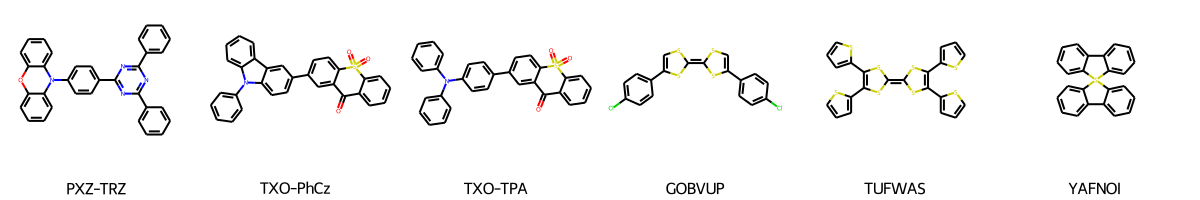

In [50]:
parent_mols = [Chem.MolFromSmiles(smi) for smi in smi_dict.values()]
mut_mols = [Chem.MolFromSmiles(smi) for smi in df.query("fp_score == 1")['SMILES']]
legends = [name for name in smi_dict.keys()]
for i, smi in enumerate(parent_data['SMILES']):
    print(smi,parent_data['molecule'][i])
img=Draw.MolsToGridImage(mols,molsPerRow=6,legends=legends)
img

c1ccc(-c2nc(-c3ccccc3)nc(-c3ccc(N4c5ccccc5Oc5ccccc54)cc3)n2)cc1 PXZ-TRZ_99
O=C1c2ccccc2S(=O)(=O)c2ccc(-c3ccc4c(c3)c3ccccc3n4-c3ccccc3)cc21 TXO-PhCz_1263
O=C1c2ccccc2S(=O)(=O)c2ccc(-c3ccc(N(c4ccccc4)c4ccccc4)cc3)cc21 TXO-TPA_1165
Clc1ccc(C2=CSC(=C3SC=C(c4ccc(Cl)cc4)S3)S2)cc1 GOBVUP_77
c1csc(C2=C(c3cccs3)SC(=C3SC(c4cccs4)=C(c4cccs4)S3)S2)c1 TUFWAS_1972
c1ccc2c(c1)-c1ccccc1S21c2ccccc2-c2ccccc21 YAFNOI_1555


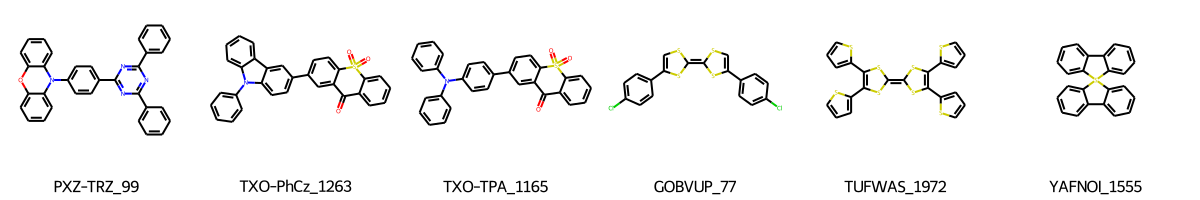

In [51]:
legends = [name for name in df.query("fp_score == 1")['molecule']]
for i, smi in enumerate(df.query("fp_score == 1")['SMILES']):
    print(smi,df.query("fp_score == 1")['molecule'].values[i])
img=Draw.MolsToGridImage(mut_mols,molsPerRow=6,legends=legends)
img

does this mean there are duplicates?

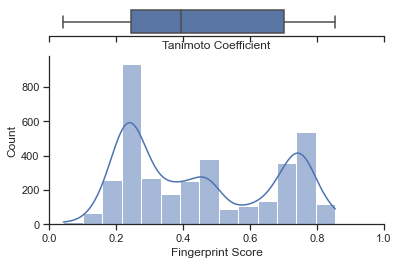

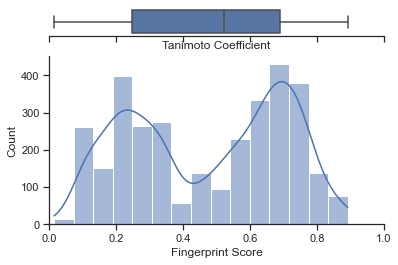

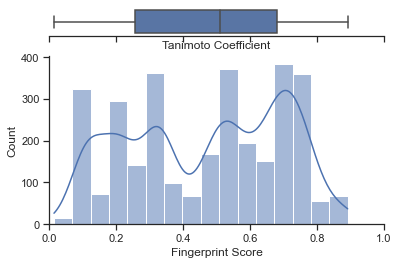

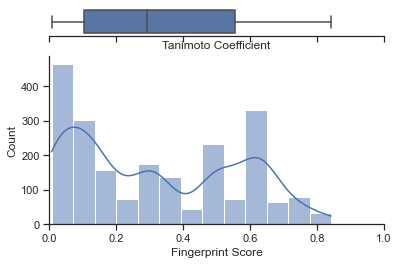

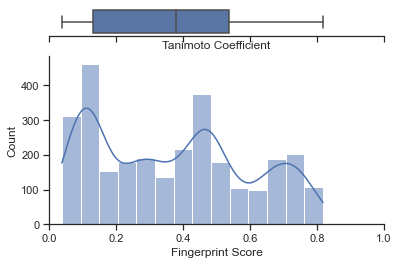

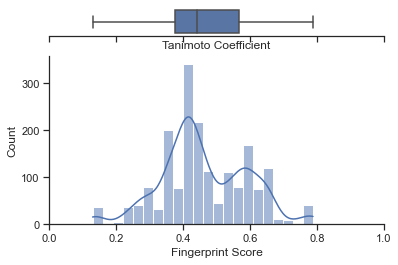

In [52]:
sns.set(style="ticks")

for i,Family in enumerate(parent_data['molecule']):
    fam = parent_data['molecule'][i]
    atom_thresh = parent_data['n_atoms'][i] - 10
    parent_natoms = parent_data['n_atoms'][i]
    
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
    df_filter = df.query("Family == @fam").query("Natoms >= (@parent_natoms - @atom_thresh)").query("fp_score != 1")#.query("shell_type == 'Closed'")
    sns.boxplot(data=df_filter,x='fp_score', ax=ax_box)
    sns.histplot(data=df_filter,x='fp_score', ax=ax_hist, kde=True)
    
    ax_box.set_xlabel("Tanimoto Coefficient")
#     ax_box.set_ylabel("Fingerprint Score")
    ax_hist.set_xlabel("Fingerprint Score")
#     ax_hist.set_ylabel("Fingerprint Score")

    ax_box.set(yticks=[])
    sns.despine(ax=ax_hist)
    sns.despine(ax=ax_box, left=True)
    plt.xlim(0, 1)
    plt.savefig('Images/sns_plt_'+fam+'_fpSimilarity2parent.png', bbox_inches='tight',dpi=img_dpi)

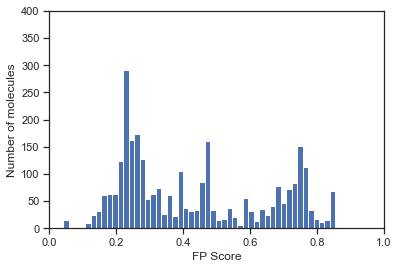

without any filter 1925
After natoms and shell_type filter 2929 difference= -1004


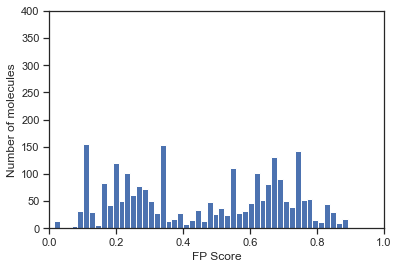

without any filter 1925
After natoms and shell_type filter 2488 difference= -563


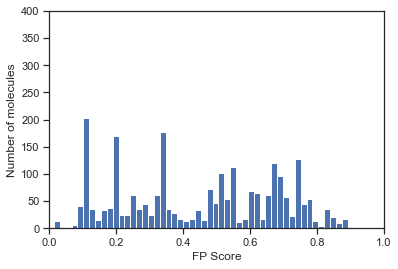

without any filter 1925
After natoms and shell_type filter 2420 difference= -495


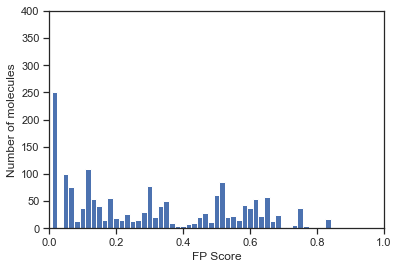

without any filter 1925
After natoms and shell_type filter 1687 difference= 238


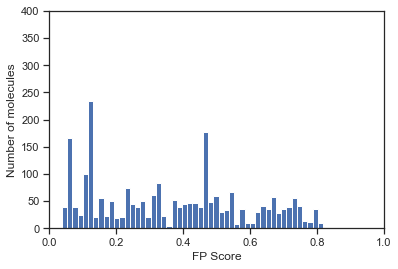

without any filter 1925
After natoms and shell_type filter 2373 difference= -448


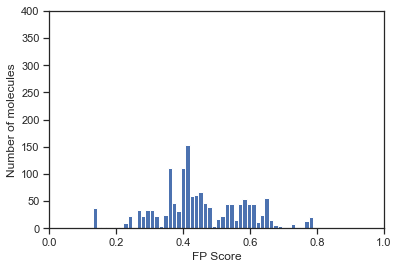

without any filter 1925
After natoms and shell_type filter 1475 difference= 450


In [85]:
df = pd.DataFrame(all_data)
for i,smi in enumerate(parent_data['SMILES']):
    
    fam = parent_data['molecule'][i]
    atom_thresh = parent_data['n_atoms'][i] - 10
    parent_natoms = parent_data['n_atoms'][i]
    
    df_filter = df.query("Family == @fam").query("Natoms >= (@parent_natoms - @atom_thresh)").query("shell_type == 'Closed'").query("fp_score != 1")
    df_filter['fp_score'].plot.hist(bins=50)
#     plt.title(fam)
    plt.xlabel("FP Score")
    plt.ylabel("Number of molecules")
    plt.ylim(0, 400)
    plt.xlim(0, 1)
    plt.savefig('Images/hist_'+fam+'_fpSimilarity_FILTERED.png', bbox_inches='tight',dpi=img_dpi)
    plt.show()
    print("without any filter", df.query("Family == @family").shape[0])
    print("After natoms and shell_type filter", df_filter.shape[0], 'difference=',df.query("Family == @family").shape[0]-df_filter.shape[0])

# How the molecules compare to each other? 2D Similarity map
are the molcules generated difference to each other?

# THIS TAKES A LOT OF TIME

In [86]:
all_mol_fp_data = {}
all_mol_fp_data['Family'] = []
all_mol_fp_data['fp_score'] = []
all_mol_fp_data['molecule'] = []
df = pd.DataFrame(all_data)
for fam in parent_data['molecule']:
    df_filter = df.query("Family == @fam").query("Natoms >= (@parent_natoms - @atom_thresh)").query("fp_score != 1")#.query("shell_type == 'closed'")
    df_filter_sorted = df_filter.sort_values(by='fp_score')
    
    smis = list(df_filter_sorted['SMILES'])
    mol_names = list(df_filter_sorted['molecule'])
    
    
    for i,smi in enumerate(smis):
        all_mol_fp_data['Family'].append(fam)
        all_mol_fp_data['molecule'].append(mol_names[i])
        all_mol_fp_data['fp_score'].append(Stoned.get_fp_scores(smis,target_smi=smi,fp_type=fp_type))   

# STORE OUTPUT SO YOU DONT HAVE TO RUN AGAIN

In [87]:
# pickle.dump(all_mol_fp_data, open("all_mol_fp_data.pkl",'wb'))

### load `all_mol_fp_data`

In [88]:
all_mol_fp_data = pickle.load(open("all_mol_fp_data.pkl",'rb'))

In [89]:
pd.DataFrame(all_mol_fp_data)

Family                                           fp_score  \
0      PXZ-TRZ  [1.0, 0.6, 0.6, 0.6, 0.6, 0.7297297297297297, ...   
1      PXZ-TRZ  [0.6, 1.0, 0.6, 0.6, 0.6, 0.6, 0.7297297297297...   
2      PXZ-TRZ  [0.6, 0.6, 1.0, 0.7297297297297297, 0.72972972...   
3      PXZ-TRZ  [0.6, 0.6, 0.7297297297297297, 1.0, 0.72972972...   
4      PXZ-TRZ  [0.6, 0.6, 0.7297297297297297, 0.7297297297297...   
...        ...                                                ...   
16973   YAFNOI  [0.12745098039215685, 0.12745098039215685, 0.1...   
16974   YAFNOI  [0.12745098039215685, 0.12745098039215685, 0.1...   
16975   YAFNOI  [0.12745098039215685, 0.12745098039215685, 0.1...   
16976   YAFNOI  [0.12745098039215685, 0.12745098039215685, 0.1...   
16977   YAFNOI  [0.12745098039215685, 0.12745098039215685, 0.1...   

           molecule  
0      PXZ-TRZ_1719  
1      PXZ-TRZ_1188  
2      PXZ-TRZ_2785  
3       PXZ-TRZ_344  
4        PXZ-TRZ_82  
...             ...  
16973    YAFNOI_521  
16974   YAFNOI_1257  
16975   YAFNOI_1784  
16976   YAFNOI_1117  
16977   YAFNOI_1884  

[16978 rows x 3 columns]

# What does the output look like?

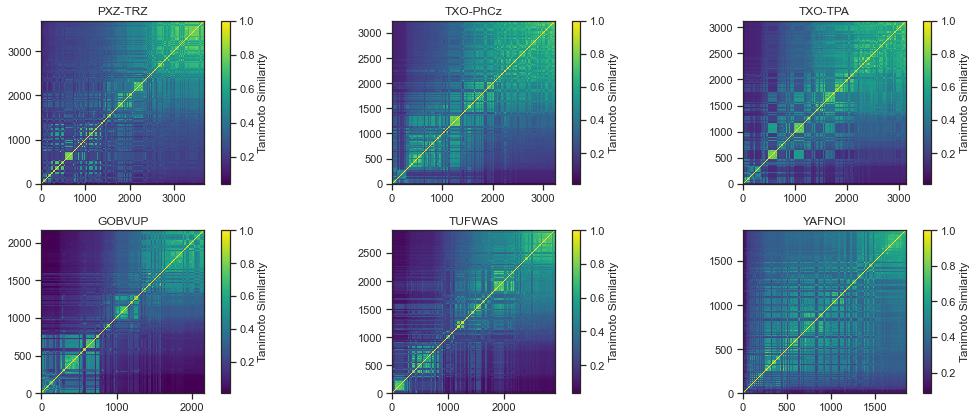

In [90]:
df = pd.DataFrame(all_mol_fp_data)
fig, axs = plt.subplots(2,3, figsize=(15, 6))

i = 0
j = 0
for name in smi_dict:
    ax = axs[i][j] 
    array = np.array([x for x in df.query("Family == @name")['fp_score']])
    plot = ax.imshow(array, interpolation='none',origin='lower',cmap="viridis")
    fig.colorbar(plot, ax=ax, label='Tanimoto Coefficient')
    ax.title.set_text(name)
    if j <2:
        j += 1
    elif j == 2:
        i = 1
        j=0
        
# fig.suptitle('Finger Print score similarity 2D map')
fig.tight_layout()
plt.show()

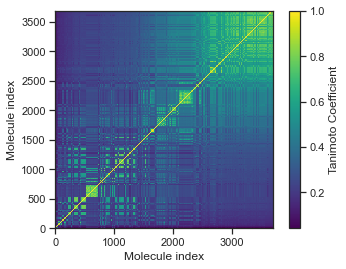

PXZ-TRZ


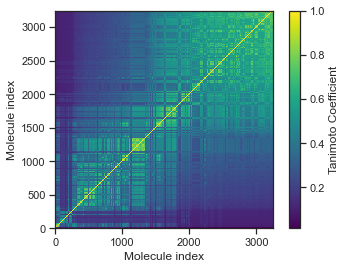

TXO-PhCz


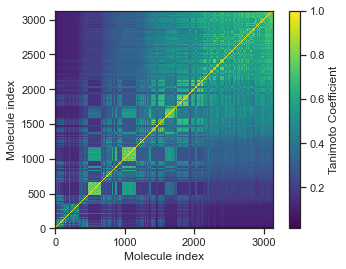

TXO-TPA


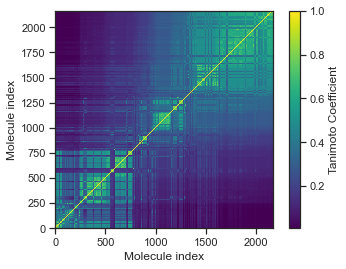

GOBVUP


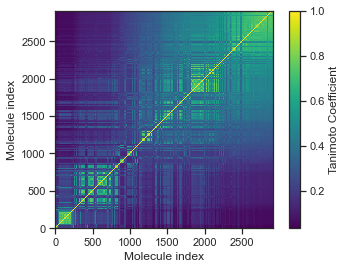

TUFWAS


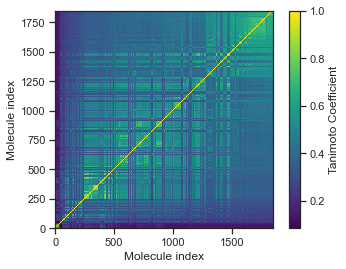

YAFNOI


In [91]:
df = pd.DataFrame(all_mol_fp_data)
for name in smi_dict:
    array = np.array([x for x in df.query("Family == @name")['fp_score']])
    plt.imshow(array, interpolation='none',origin='lower',cmap="viridis")
    plt.colorbar(label='Tanimoto Coefficient')
#     plt.title(name)
    plt.xlabel('Molecule index')
    plt.ylabel('Molecule index')
    plt.savefig('Images/2DSimilarityMAP_'+name+'_FILTERED.png', bbox_inches='tight',dpi=200)

    plt.show()
    print(name)

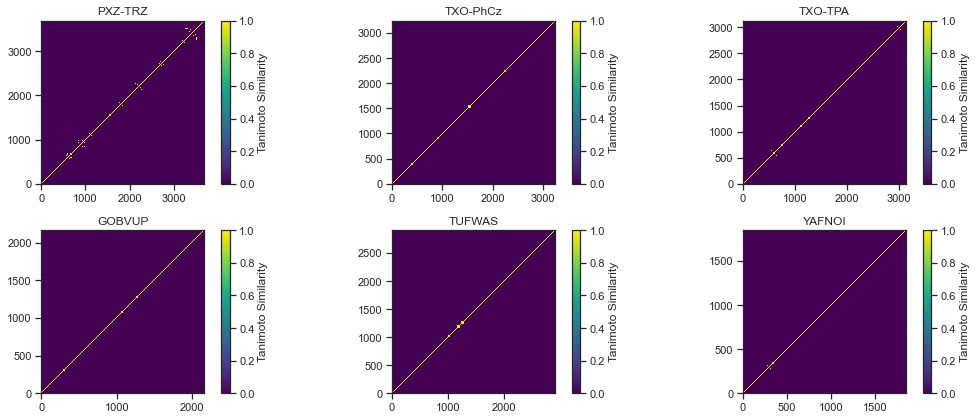

In [63]:
df = pd.DataFrame(all_mol_fp_data)
fig, axs = plt.subplots(2,3, figsize=(15, 6))

i = 0
j = 0
for name in smi_dict:
    ax = axs[i][j] 
    array = np.array([x for x in df.query("Family == @name")['fp_score']])
    array_b = (array>.85).astype(int)
    plot = ax.imshow(array_b, interpolation='nearest',origin='lower',cmap="viridis")
    fig.colorbar(plot, ax=ax, label='Tanimoto Similarity')
    ax.title.set_text(name)
    if j <2:
        j += 1
    elif j == 2:
        i = 1
        j=0
        
# fig.suptitle('Finger Print score similarity 2D map')
fig.tight_layout()
plt.show()

{1} {1.0}
3688 3688


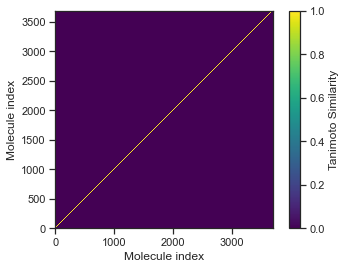

PXZ-TRZ
{1} {1.0}
3243 3243


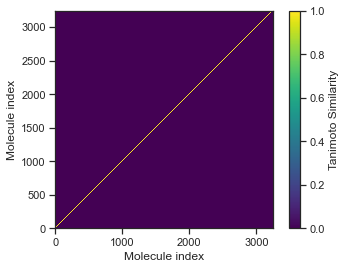

TXO-PhCz
{1} {1.0}
3128 3128


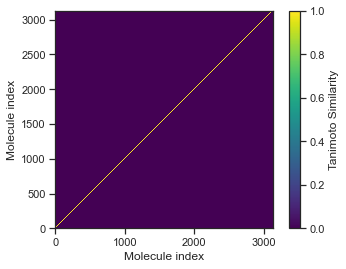

TXO-TPA
{1} {1.0}
2164 2164


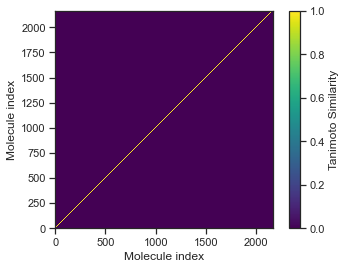

GOBVUP
{1} {1.0}
2906 2906


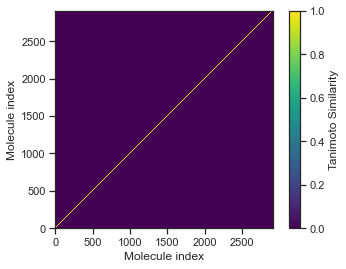

TUFWAS
{1} {1.0}
1849 1849


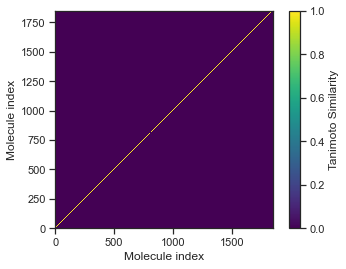

YAFNOI


In [64]:
df = pd.DataFrame(all_mol_fp_data)
for name in smi_dict:
    array = np.array([x for x in df.query("Family == @name")['fp_score']])
    array_b = (array==1).astype(int)
    
    #create a fake array to see if it fixes the problem
    n = len(np.diag(array_b))
    fake_arrayb = np.eye(n)
    plt.imshow(fake_arrayb, interpolation='none',origin='lower',cmap="viridis")
    print(set(np.diag(array_b)), set(np.diag(fake_arrayb))) #print only values in diagonal array
    print(len(np.diag(array_b)),len(np.diag(fake_arrayb))) #length of the diagonal
    
#     plt.imshow(array_b, interpolation='none',origin='lower',cmap="viridis")
    plt.colorbar(label='Tanimoto Similarity')
#     plt.title(name)
    plt.xlabel('Molecule index')
    plt.ylabel('Molecule index')
    plt.savefig('Images/2DSimilarityMAP_binary_'+name+'_FILTERED.png', bbox_inches='tight',dpi=200)

    plt.show()
    print(name)

this code below shows that there show that there is no values less than 1. In other words all values are in the diagonal == 1.

Not sure why in the final image there is a break in the diagonal

In [101]:
for name in smi_dict:
    array = np.array([x for x in df.query("Family == @name")['fp_score']])
    array_b = (array==1).astype(int)
#     print(set(np.diag(array_b)), set(np.diag(array_b)))
    for x in np.diag(array_b):
        if x != 1 or x == 0:
            print(name)
            print(x)

In [94]:
len(np.eye(n))

1410

In [93]:
len(array_b)

1410

# all molecules without filtering

In [8]:
all_mol_fp_data_UNFILTERED = pickle.load(open("all_mol_fp_data_UNFILTERED.pkl",'rb'))

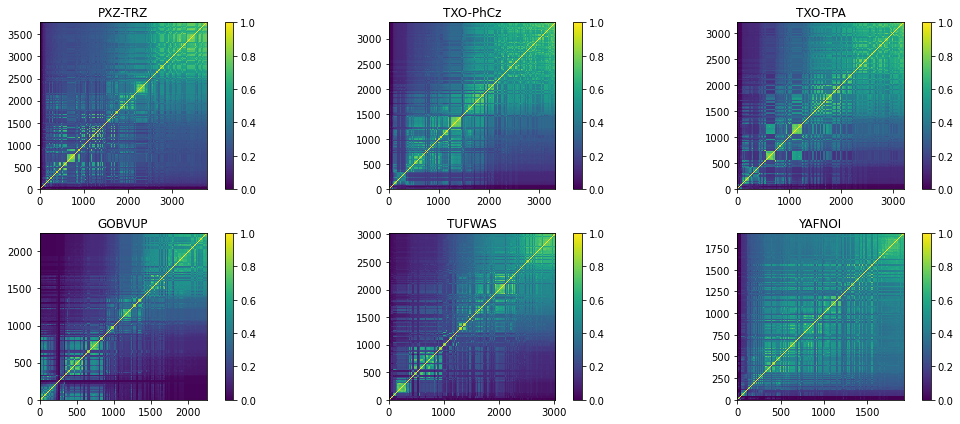

In [9]:
fig, axs = plt.subplots(2,3, figsize=(15, 6))

i = 0
j = 0
for name in smi_dict:
    ax = axs[i][j] 
    plot = ax.imshow(all_mol_fp_data_UNFILTERED[name], interpolation='nearest',origin='lower',cmap="viridis")
    fig.colorbar(plot, ax=ax)
    ax.title.set_text(name)
    if j <2:
        j += 1
    elif j == 2:
        i = 1
        j=0
        
# fig.suptitle('Finger Print score similarity 2D map')
fig.tight_layout()
plt.show()

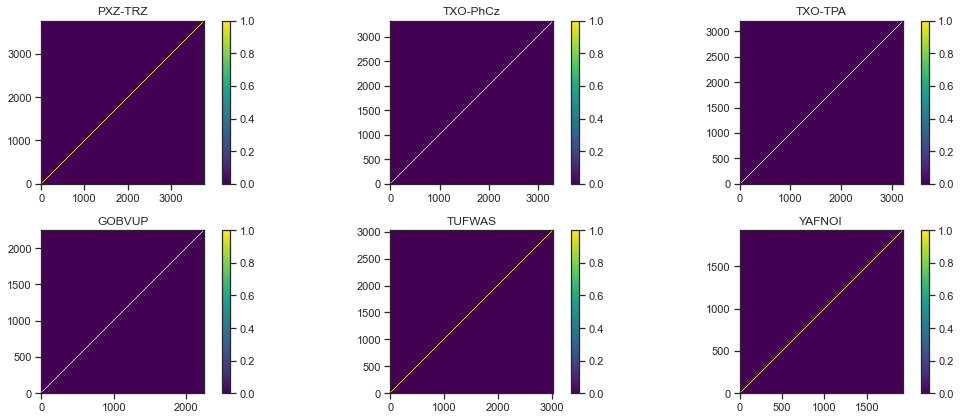

In [60]:
fig, axs = plt.subplots(2,3, figsize=(15, 6))

i = 0
j = 0
for name in smi_dict:
    ax = axs[i][j] 
    array_b = (all_mol_fp_data_UNFILTERED[name]==1).astype(int)
    plot = ax.imshow(array_b, interpolation='nearest',origin='lower',cmap="viridis")
    fig.colorbar(plot, ax=ax)
    ax.title.set_text(name)
    if j <2:
        j += 1
    elif j == 2:
        i = 1
        j=0
        
# fig.suptitle('Finger Print score similarity 2D map')
fig.tight_layout()
plt.show()

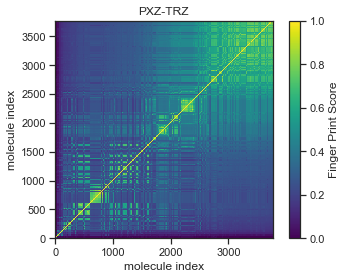

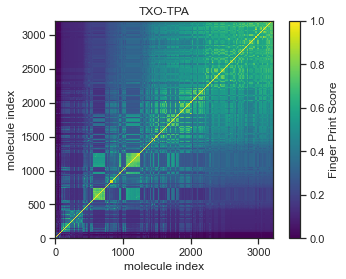

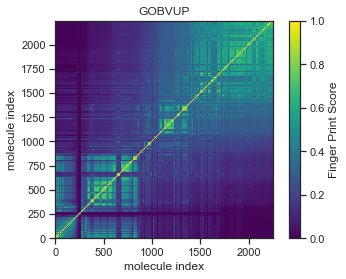

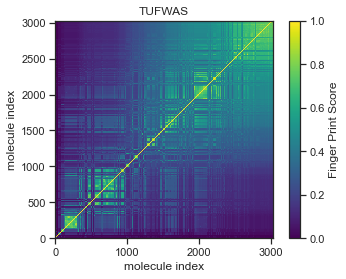

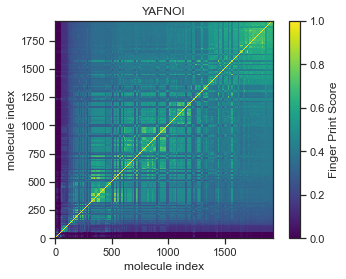

In [61]:
for name in smi_dict:
    array = all_mol_fp_data_UNFILTERED[name]
    plt.imshow(array, interpolation='nearest',origin='lower',cmap="viridis")
    plt.colorbar(label='Finger Print Score')
    plt.title(name)
    plt.xlabel('molecule index')
    plt.ylabel('molecule index')
    plt.show()

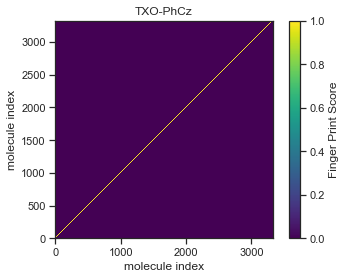

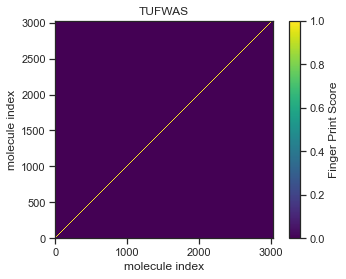

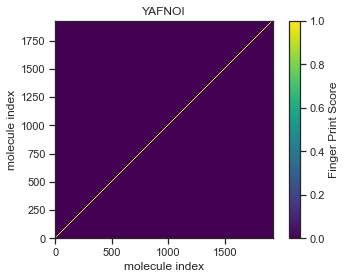

In [62]:
for name in smi_dict:
    array = all_mol_fp_data_UNFILTERED[name]
    array_b = (all_mol_fp_data_UNFILTERED[name]==1).astype(int)
    plt.imshow(array_b, interpolation='nearest',origin='lower',cmap="viridis")
    plt.colorbar(label='Finger Print Score')
    plt.title(name)
    plt.xlabel('molecule index')
    plt.ylabel('molecule index')
    plt.show()

In [ ]:
fig, axs = plt.subplots(2,3, figsize=(15, 6))

i = 0
j = 0
for name in smi_dict:
    ax = axs[i][j] 
    plot = ax.imshow(all_mol_fp_data_UNFILTERED[name], interpolation='nearest',origin='lower',cmap="viridis")
    fig.colorbar(plot, ax=ax)
    ax.title.set_text(name)
    if j <2:
        j += 1
    elif j == 2:
        i = 1
        j=0
        
# fig.suptitle('Finger Print score similarity 2D map')
fig.tight_layout()
plt.show()

In [53]:
# Dump data to be used for next step
pickle.dump(the_data, open("the_data.pkl",'wb'))